# End-to-end Learning with Autoencoders

In this notebook, you will learn how to implement an end-to-end communication system as an autoencoder [1].
The implemented system is shown in the figure below.
An additive white Gaussian noise (AWGN) channel is considered.
On the transmitter side, joint training of the constellation geometry and bit-labeling is performed, as in [2].
On the receiver side, a neural network-based demapper that computes log-likelihood ratios (LLRs) on the transmitted bits from the received samples is optimized.
The considered autoencoder is benchmarked against a quadrature amplitude modulation (QAM) with Gray labeling and the optimal AWGN demapper.

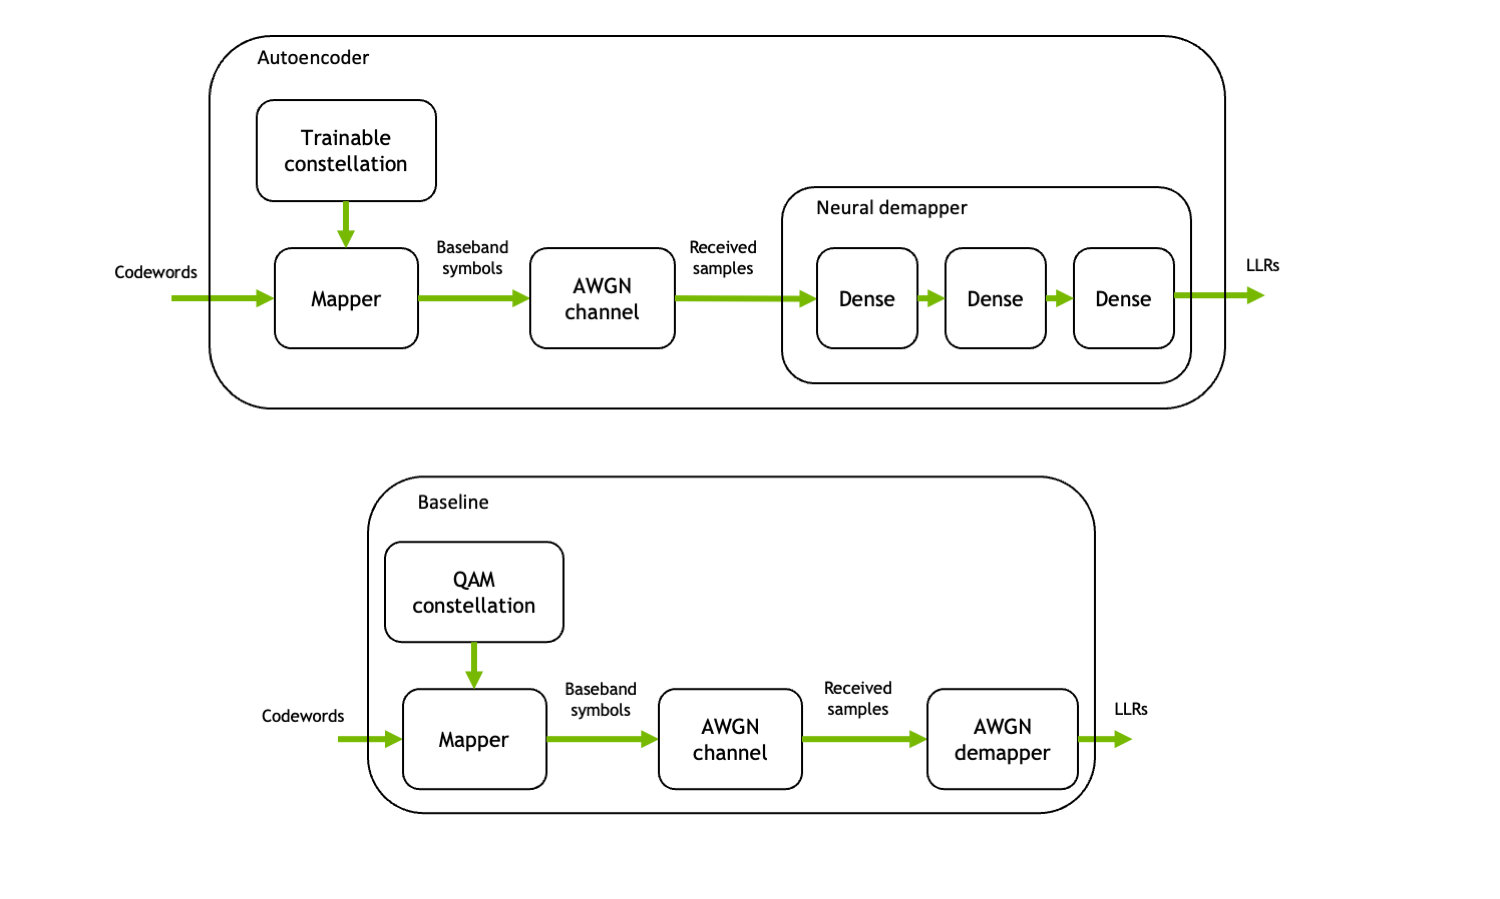


Two algorithms for training the autoencoder are implemented in this notebook:

* Conventional stochastic gradient descent (SGD) with backpropagation, which assumes a differentiable channel model and therefore optimizes the end-to-end system by backpropagating the gradients through the channel (see, e.g., [1]).
* The training algorithm from [3], which does not assume a differentiable channel model, and which trains the end-to-end system by alternating between conventional training of the receiver and reinforcement learning (RL)-based training of the transmitter. Compared to [3], an additional step of fine-tuning of the receiver is performed after alternating training.

**Note:** For an introduction to the implementation of differentiable communication systems and their optimization through SGD and backpropagation with Sionna, please refer to [the Part 2 of the Sionna tutorial for Beginners](https://nvlabs.github.io/sionna/examples/Sionna_tutorial_part2.html).

* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [Simulation Parameters](#Simulation-Parameters)
* [Neural Demapper](#Neural-Demapper)
* [Trainable End-to-end System: Conventional Training](#Trainable-End-to-end-System:-Conventional-Training)
* [Trainable End-to-end System: RL-based Training](#Trainable-End-to-end-System:-RL-based-Training)
* [Evaluation](#Evaluation)
* [Visualizing the Learned Constellations](#Visualizing-the-Learned-Constellations)
* [References](#References)

## GPU Configuration and Imports

In [1]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense

from sionna.channel import AWGN
from sionna.utils import BinarySource, ebnodb2no, log10, expand_to_rank, insert_dims
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.mapping import Mapper, Demapper, Constellation
from sionna.utils import sim_ber

sionna.config.seed = 42 # Set seed for reproducible random number generation

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

## Simulation Parameters

In [2]:
###############################################
# SNR range for evaluation and training [dB]
###############################################
ebno_db_min = 4.0
ebno_db_max = 8.0

###############################################
# Modulation and coding configuration
###############################################
num_bits_per_symbol = 6 # Baseline is 64-QAM
modulation_order = 2**num_bits_per_symbol
coderate = 0.5 # Coderate for the outer code
n = 1500 # Codeword length [bit]. Must be a multiple of num_bits_per_symbol
num_symbols_per_codeword = n//num_bits_per_symbol # Number of modulated baseband symbols per codeword
k = int(n*coderate) # Number of information bits per codeword

###############################################
# Training configuration
###############################################
num_training_iterations_conventional = 10000 # Number of training iterations for conventional training
# Number of training iterations with RL-based training for the alternating training phase and fine-tuning of the receiver phase
num_training_iterations_rl_alt = 7000
num_training_iterations_rl_finetuning = 3000
training_batch_size = tf.constant(128, tf.int32) # Training batch size
rl_perturbation_var = 0.01 # Variance of the perturbation used for RL-based training of the transmitter
model_weights_path_conventional_training = "awgn_autoencoder_weights_conventional_training" # Filename to save the autoencoder weights once conventional training is done
model_weights_path_rl_training = "awgn_autoencoder_weights_rl_training" # Filename to save the autoencoder weights once RL-based training is done

###############################################
# Evaluation configuration
###############################################
results_filename = "awgn_autoencoder_results" # Location to save the results

## Neural Demapper

The neural network-based demapper shown in the figure above is made of three dense layers with ReLU activation.

The input of the demapper consists of a received sample $y \in \mathbb{C}$ and the noise power spectral density $N_0$ in log-10 scale to handle different orders of magnitude for the SNR.

As the neural network can only process real-valued inputs, these values are fed as a 3-dimensional vector

$$\left[ \mathcal{R}(y), \mathcal{I}(y), \log_{10}(N_0) \right]$$

where $\mathcal{R}(y)$ and $\mathcal{I}(y)$ refer to the real and imaginary component of $y$, respectively.

The output of the neural network-based demapper consists of LLRs on the `num_bits_per_symbol` bits mapped to a constellation point. Therefore, the last layer consists of ``num_bits_per_symbol`` units.

**Note**: The neural network-based demapper processes the received samples $y$ forming a block individually. The [neural receiver notebook](https://nvlabs.github.io/sionna/examples/Neural_Receiver.html) provides an example of a more advanced neural network-based receiver that jointly processes a resource grid of received symbols.

In [3]:
class NeuralDemapper(Layer):

    def __init__(self):
        super().__init__()

        self._dense_1 = Dense(128, 'relu')
        self._dense_2 = Dense(128, 'relu')
        self._dense_3 = Dense(num_bits_per_symbol, None) # The feature correspond to the LLRs for every bits carried by a symbol

    def call(self, inputs):
        y,no = inputs

        # Using log10 scale helps with the performance
        no_db = log10(no)

        # Stacking the real and imaginary components of the complex received samples
        # and the noise variance
        no_db = tf.tile(no_db, [1, num_symbols_per_codeword]) # [batch size, num_symbols_per_codeword]
        z = tf.stack([tf.math.real(y),
                      tf.math.imag(y),
                      no_db], axis=2) # [batch size, num_symbols_per_codeword, 3]
        llr = self._dense_1(z)
        llr = self._dense_2(llr)
        llr = self._dense_3(llr) # [batch size, num_symbols_per_codeword, num_bits_per_symbol]

        return llr

## Trainable End-to-end System: Conventional Training

The following cell defines an end-to-end communication system that transmits bits modulated using a trainable constellation over an AWGN channel.

The receiver uses the previously defined neural network-based demapper to compute LLRs on the transmitted (coded) bits.

As in [1], the constellation and neural network-based demapper are jointly trained through SGD and backpropagation using the binary cross entropy (BCE) as loss function.

Training on the BCE is known to be equivalent to maximizing an achievable information rate [2].

The following model can be instantiated either for training (`training = True`) or evaluation (`training = False`).

In the former case, the BCE is returned and no outer code is used to reduce computational complexity and as it does not impact the training of the constellation or demapper.

When setting `training` to `False`, an LDPC outer code from 5G NR is applied.

In [4]:
class E2ESystemConventionalTraining(Model):

    def __init__(self, training):
        super().__init__()

        self._training = training

        ################
        ## Transmitter
        ################
        self._binary_source = BinarySource()
        # To reduce the computational complexity of training, the outer code is not used when training,
        # as it is not required
        if not self._training:
            # num_bits_per_symbol is required for the interleaver
            self._encoder = LDPC5GEncoder(k, n, num_bits_per_symbol)
        # Trainable constellation
        constellation = Constellation("qam", num_bits_per_symbol, trainable=True)
        self.constellation = constellation
        self._mapper = Mapper(constellation=constellation)

        ################
        ## Channel
        ################
        self._channel = AWGN()

        ################
        ## Receiver
        ################
        # We use the previously defined neural network for demapping
        self._demapper = NeuralDemapper()
        # To reduce the computational complexity of training, the outer code is not used when training,
        # as it is not required
        if not self._training:
            self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

        #################
        # Loss function
        #################
        if self._training:
            self._bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    @tf.function(jit_compile=True)
    def call(self, batch_size, ebno_db):

        # If `ebno_db` is a scalar, a tensor with shape [batch size] is created as it is what is expected by some layers
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        no = expand_to_rank(no, 2)

        ################
        ## Transmitter
        ################
        # Outer coding is only performed if not training
        if self._training:
            c = self._binary_source([batch_size, n])
        else:
            b = self._binary_source([batch_size, k])
            c = self._encoder(b)
        # Modulation
        x = self._mapper(c) # x [batch size, num_symbols_per_codeword]

        ################
        ## Channel
        ################
        y = self._channel([x, no]) # [batch size, num_symbols_per_codeword]

        ################
        ## Receiver
        ################
        llr = self._demapper([y, no])
        llr = tf.reshape(llr, [batch_size, n])
        # If training, outer decoding is not performed and the BCE is returned
        if self._training:
            loss = self._bce(c, llr)
            return loss
        else:
            # Outer decoding
            b_hat = self._decoder(llr)
            return b,b_hat # Ground truth and reconstructed information bits returned for BER/BLER computation

A simple training loop is defined in the next cell, which performs `num_training_iterations_conventional` training iterations of SGD. Training is done over a range of SNR, by randomly sampling a batch of SNR values at each iteration.

**Note:** For an introduction to the implementation of differentiable communication systems and their optimization through SGD and backpropagation with Sionna, please refer to [the Part 2 of the Sionna tutorial for Beginners](https://nvlabs.github.io/sionna/examples/Sionna_tutorial_part2.html).

In [5]:
def conventional_training(model):
    # Optimizer used to apply gradients
    optimizer = tf.keras.optimizers.Adam()

    for i in range(num_training_iterations_conventional):
        # Sampling a batch of SNRs
        ebno_db = tf.random.uniform(shape=[training_batch_size], minval=ebno_db_min, maxval=ebno_db_max)
        # Forward pass
        with tf.GradientTape() as tape:
            loss = model(training_batch_size, ebno_db) # The model is assumed to return the BMD rate
        # Computing and applying gradients
        weights = model.trainable_weights
        grads = tape.gradient(loss, weights)
        optimizer.apply_gradients(zip(grads, weights))
        # Printing periodically the progress
        if i % 100 == 0:
            print('Iteration {}/{}  BCE: {:.4f}'.format(i, num_training_iterations_conventional, loss.numpy()), end='\r')

The next cell defines a utility function for saving the weights using [pickle](https://docs.python.org/3/library/pickle.html).

In [6]:
def save_weights(model, model_weights_path):
    weights = model.get_weights()
    with open(model_weights_path, 'wb') as f:
        pickle.dump(weights, f)

In the next cell, an instance of the model defined previously is instantiated and trained.

In [7]:
# Instantiate and train the end-to-end system
model = E2ESystemConventionalTraining(training=True)
conventional_training(model)
# Save weights
save_weights(model, model_weights_path_conventional_training)

I0000 00:00:1727359472.578808  304894 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1727359472.581655  304894 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1727359472.957754  304894 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


## Trainable End-to-end System: RL-based Training

The following cell defines the same end-to-end system as before, but stop the gradients after the channel to simulate a non-differentiable channel.

To jointly train the transmitter and receiver over a non-differentiable channel, we follow [3], which key idea is to alternate between:

- Training of the receiver on the BCE using conventional backpropagation and SGD.
- Training of the transmitter by applying (known) perturbations to the transmitter output to enable estimation of the gradient of the transmitter weights with respect to an approximation of the loss function.

When `training` is set to `True`, both losses for training the receiver and the transmitter are returned.

In [8]:
class E2ESystemRLTraining(Model):

    def __init__(self, training):
        super().__init__()

        self._training = training

        ################
        ## Transmitter
        ################
        self._binary_source = BinarySource()
        # To reduce the computational complexity of training, the outer code is not used when training,
        # as it is not required
        if not self._training:
            self._encoder = LDPC5GEncoder(k, n, num_bits_per_symbol)
        # Trainable constellation
        constellation = Constellation("qam", num_bits_per_symbol, trainable=True)
        self.constellation = constellation
        self._mapper = Mapper(constellation=constellation)

        ################
        ## Channel
        ################
        self._channel = AWGN()

        ################
        ## Receiver
        ################
        # We use the previously defined neural network for demapping
        self._demapper = NeuralDemapper()
        # To reduce the computational complexity of training, the outer code is not used when training,
        # as it is not required
        if not self._training:
            self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

    @tf.function(jit_compile=True)
    def call(self, batch_size, ebno_db, perturbation_variance=tf.constant(0.0, tf.float32)):

        # If `ebno_db` is a scalar, a tensor with shape [batch size] is created as it is what is expected by some layers
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        no = expand_to_rank(no, 2)

        ################
        ## Transmitter
        ################
        # Outer coding is only performed if not training
        if self._training:
            c = self._binary_source([batch_size, n])
        else:
            b = self._binary_source([batch_size, k])
            c = self._encoder(b)
        # Modulation
        x = self._mapper(c) # x [batch size, num_symbols_per_codeword]

        # Adding perturbation
        # If ``perturbation_variance`` is 0, then the added perturbation is null
        epsilon_r = tf.random.normal(tf.shape(x))*tf.sqrt(0.5*perturbation_variance)
        epsilon_i = tf.random.normal(tf.shape(x))*tf.sqrt(0.5*perturbation_variance)
        epsilon = tf.complex(epsilon_r, epsilon_i) # [batch size, num_symbols_per_codeword]
        x_p = x + epsilon # [batch size, num_symbols_per_codeword]

        ################
        ## Channel
        ################
        y = self._channel([x_p, no]) # [batch size, num_symbols_per_codeword]
        y = tf.stop_gradient(y) # Stop gradient here

        ################
        ## Receiver
        ################
        llr = self._demapper([y, no])

        # If training, outer decoding is not performed
        if self._training:
            # Average BCE for each baseband symbol and each batch example
            c = tf.reshape(c, [-1, num_symbols_per_codeword, num_bits_per_symbol])
            bce = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(c, llr), axis=2) # Avergare over the bits mapped to a same baseband symbol
            # The RX loss is the usual average BCE
            rx_loss = tf.reduce_mean(bce)
            # From the TX side, the BCE is seen as a feedback from the RX through which backpropagation is not possible
            bce = tf.stop_gradient(bce) # [batch size, num_symbols_per_codeword]
            x_p = tf.stop_gradient(x_p)
            p = x_p-x # [batch size, num_symbols_per_codeword] Gradient is backpropagated through `x`
            tx_loss = tf.square(tf.math.real(p)) + tf.square(tf.math.imag(p)) # [batch size, num_symbols_per_codeword]
            tx_loss = -bce*tx_loss/rl_perturbation_var # [batch size, num_symbols_per_codeword]
            tx_loss = tf.reduce_mean(tx_loss)
            return tx_loss, rx_loss
        else:
            llr = tf.reshape(llr, [-1, n]) # Reshape as expected by the outer decoder
            b_hat = self._decoder(llr)
            return b,b_hat

The next cell implements the training algorithm from [3], which alternates between conventional training of the neural network-based receiver, and RL-based training of the transmitter.

In [9]:
def rl_based_training(model):
    # Optimizers used to apply gradients
    optimizer_tx = tf.keras.optimizers.Adam() # For training the transmitter
    optimizer_rx = tf.keras.optimizers.Adam() # For training the receiver

    # Function that implements one transmitter training iteration using RL.
    def train_tx():
        # Sampling a batch of SNRs
        ebno_db = tf.random.uniform(shape=[training_batch_size], minval=ebno_db_min, maxval=ebno_db_max)
        # Forward pass
        with tf.GradientTape() as tape:
            # Keep only the TX loss
            tx_loss, _ = model(training_batch_size, ebno_db,
                               tf.constant(rl_perturbation_var, tf.float32)) # Perturbation are added to enable RL exploration
        ## Computing and applying gradients
        weights = model.trainable_weights
        grads = tape.gradient(tx_loss, weights)
        optimizer_tx.apply_gradients(zip(grads, weights))

    # Function that implements one receiver training iteration
    def train_rx():
        # Sampling a batch of SNRs
        ebno_db = tf.random.uniform(shape=[training_batch_size], minval=ebno_db_min, maxval=ebno_db_max)
        # Forward pass
        with tf.GradientTape() as tape:
            # Keep only the RX loss
            _, rx_loss = model(training_batch_size, ebno_db) # No perturbation is added
        ## Computing and applying gradients
        weights = model.trainable_weights
        grads = tape.gradient(rx_loss, weights)
        optimizer_rx.apply_gradients(zip(grads, weights))
        # The RX loss is returned to print the progress
        return rx_loss

    # Training loop.
    for i in range(num_training_iterations_rl_alt):
        # 10 steps of receiver training are performed to keep it ahead of the transmitter
        # as it is used for computing the losses when training the transmitter
        for _ in range(10):
            rx_loss = train_rx()
        # One step of transmitter training
        train_tx()
        # Printing periodically the progress
        if i % 100 == 0:
            print('Iteration {}/{}  BCE {:.4f}'.format(i, num_training_iterations_rl_alt, rx_loss.numpy()), end='\r')
    print() # Line break

    # Once alternating training is done, the receiver is fine-tuned.
    print('Receiver fine-tuning... ')
    for i in range(num_training_iterations_rl_finetuning):
        rx_loss = train_rx()
        if i % 100 == 0:
            print('Iteration {}/{}  BCE {:.4f}'.format(i, num_training_iterations_rl_finetuning, rx_loss.numpy()), end='\r')

In the next cell, an instance of the model defined previously is instantiated and trained.

In [10]:
# Instantiate and train the end-to-end system
model = E2ESystemRLTraining(training=True)
rl_based_training(model)
# Save weights
save_weights(model, model_weights_path_rl_training)

W0000 00:00:1727359521.657593  304894 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1727359521.999966  304894 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Iteration 6900/7000  BCE 0.2826
Receiver fine-tuning... 


## Evaluation

The following cell implements a baseline which uses QAM with Gray labeling and conventional demapping for AWGN channel.

In [11]:
class Baseline(Model):

    def __init__(self):
        super().__init__()

        ################
        ## Transmitter
        ################
        self._binary_source = BinarySource()
        self._encoder = LDPC5GEncoder(k, n, num_bits_per_symbol)
        constellation = Constellation("qam", num_bits_per_symbol, trainable=False)
        self.constellation = constellation
        self._mapper = Mapper(constellation=constellation)

        ################
        ## Channel
        ################
        self._channel = AWGN()

        ################
        ## Receiver
        ################
        self._demapper = Demapper("app", constellation=constellation)
        self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

    @tf.function(jit_compile=True)
    def call(self, batch_size, ebno_db, perturbation_variance=tf.constant(0.0, tf.float32)):

        # If `ebno_db` is a scalar, a tensor with shape [batch size] is created as it is what is expected by some layers
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        no = expand_to_rank(no, 2)

        ################
        ## Transmitter
        ################
        b = self._binary_source([batch_size, k])
        c = self._encoder(b)
        # Modulation
        x = self._mapper(c) # x [batch size, num_symbols_per_codeword]

        ################
        ## Channel
        ################
        y = self._channel([x, no]) # [batch size, num_symbols_per_codeword]

        ################
        ## Receiver
        ################
        llr = self._demapper([y, no])
        # Outer decoding
        b_hat = self._decoder(llr)
        return b,b_hat # Ground truth and reconstructed information bits returned for BER/BLER computation

In [12]:
# Range of SNRs over which the systems are evaluated
ebno_dbs = np.arange(ebno_db_min, # Min SNR for evaluation
                     ebno_db_max, # Max SNR for evaluation
                     0.5) # Step

In [13]:
# Utility function to load and set weights of a model
def load_weights(model, model_weights_path):
    model(1, tf.constant(10.0, tf.float32))
    with open(model_weights_path, 'rb') as f:
        weights = pickle.load(f)
    model.set_weights(weights)

The next cell evaluate the baseline and the two autoencoder-based communication systems, trained with different method.
The results are stored in the dictionary ``BLER``.

In [14]:
# Dictionary storing the results
BLER = {}

model_baseline = Baseline()
_,bler = sim_ber(model_baseline, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=1000)
BLER['baseline'] = bler.numpy()

model_conventional = E2ESystemConventionalTraining(training=False)
load_weights(model_conventional, model_weights_path_conventional_training)
_,bler = sim_ber(model_conventional, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=1000)
BLER['autoencoder-conv'] = bler.numpy()

model_rl = E2ESystemRLTraining(training=False)
load_weights(model_rl, model_weights_path_rl_training)
_,bler = sim_ber(model_rl, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=1000)
BLER['autoencoder-rl'] = bler.numpy()

with open(results_filename, 'wb') as f:
    pickle.dump((ebno_dbs, BLER), f)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      4.0 | 1.2224e-01 | 1.0000e+00 |       93879 |      768000 |         1024 |        1024 |         4.2 |reached target block errors
      4.5 | 9.6033e-02 | 9.9316e-01 |       73753 |      768000 |         1017 |        1024 |         0.1 |reached target block errors
      5.0 | 5.8314e-02 | 9.2361e-01 |       50383 |      864000 |         1064 |        1152 |         0.1 |reached target block errors
      5.5 | 1.9398e-02 | 5.1807e-01 |       29795 |     1536000 |         1061 |        2048 |         0.2 |reached target block errors
      6.0 | 2.4055e-03 | 1.0841e-01 |       16858 |     7008000 |         1013 |        9344 |         0.7 |reached target block errors
      6.5 | 1.2388e-04 | 9.1788e-03 |       10132 |    81792000 |

W0000 00:00:1727359944.593152  304894 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      4.0 | 1.0766e-01 | 9.9805e-01 |       82682 |      768000 |         1022 |        1024 |         2.2 |reached target block errors
      4.5 | 6.6502e-02 | 9.2882e-01 |       57458 |      864000 |         1070 |        1152 |         0.1 |reached target block errors
      5.0 | 2.5940e-02 | 5.8259e-01 |       34864 |     1344000 |         1044 |        1792 |         0.1 |reached target block errors
      5.5 | 4.1644e-03 | 1.5411e-01 |       20389 |     4896000 |         1006 |        6528 |         0.5 |reached target block errors
      6.0 | 2.6606e-04 | 1.6276e-02 |       12260 |    46080000 |         1000 |       61440 |         4.5 |reached target block errors
      6.5 | 9.2396e-06 | 9.6875e-04 |         887 |    96000000 |

W0000 00:00:1727359983.180041  304894 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      4.0 | 1.0375e-01 | 9.9707e-01 |       79683 |      768000 |         1021 |        1024 |         2.4 |reached target block errors
      4.5 | 6.4654e-02 | 8.9410e-01 |       55861 |      864000 |         1030 |        1152 |         0.1 |reached target block errors
      5.0 | 2.3414e-02 | 5.4375e-01 |       33716 |     1440000 |         1044 |        1920 |         0.1 |reached target block errors
      5.5 | 3.6796e-03 | 1.3524e-01 |       20488 |     5568000 |         1004 |        7424 |         0.5 |reached target block errors
      6.0 | 2.6294e-04 | 1.5259e-02 |       12924 |    49152000 |         1000 |       65536 |         4.8 |reached target block errors
      6.5 | 1.1604e-05 | 8.5156e-04 |        1114 |    96000000 |

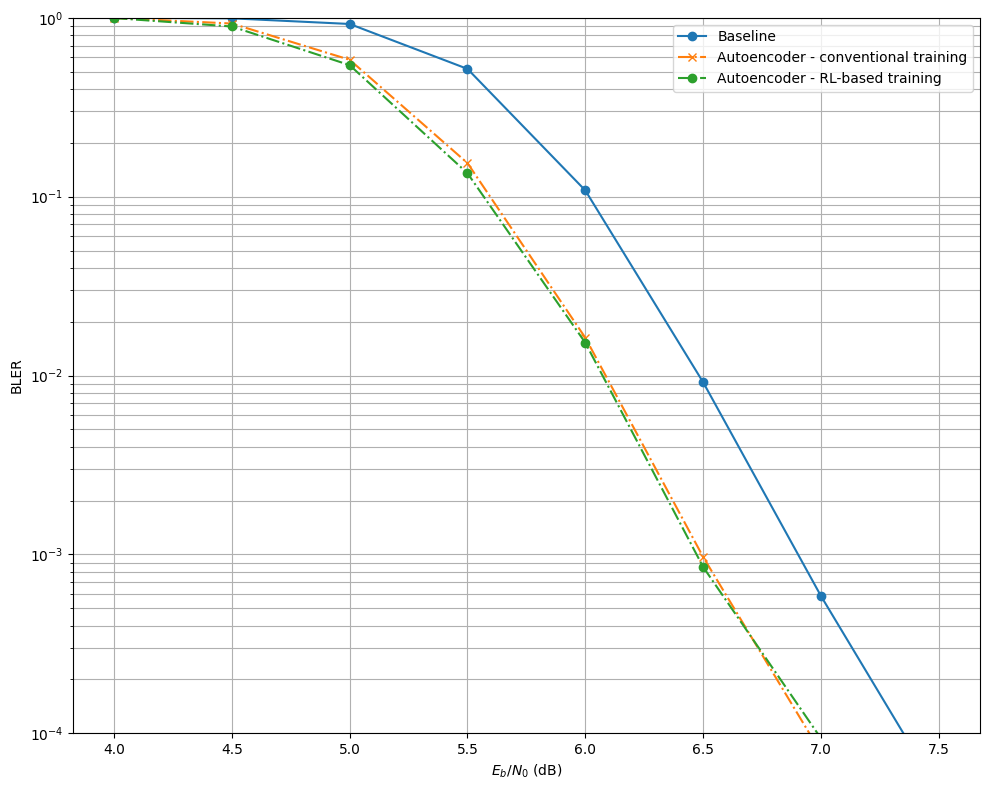

In [15]:
plt.figure(figsize=(10,8))
# Baseline - Perfect CSI
plt.semilogy(ebno_dbs, BLER['baseline'], 'o-', c=f'C0', label=f'Baseline')
# Autoencoder - conventional training
plt.semilogy(ebno_dbs, BLER['autoencoder-conv'], 'x-.', c=f'C1', label=f'Autoencoder - conventional training')
# Autoencoder - RL-based training
plt.semilogy(ebno_dbs, BLER['autoencoder-rl'], 'o-.', c=f'C2', label=f'Autoencoder - RL-based training')

plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BLER")
plt.grid(which="both")
plt.ylim((1e-4, 1.0))
plt.legend()
plt.tight_layout()

## Visualizing the Learned Constellations

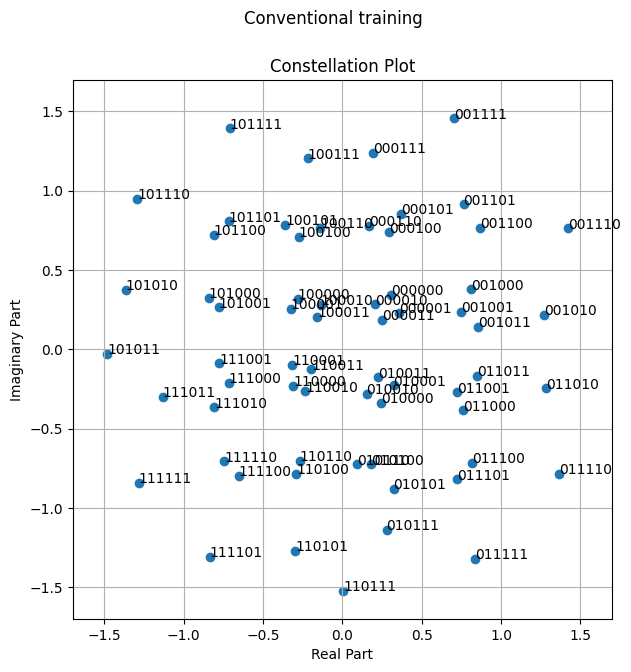

In [16]:
model_conventional = E2ESystemConventionalTraining(training=True)
load_weights(model_conventional, model_weights_path_conventional_training)
fig = model_conventional.constellation.show()
fig.suptitle('Conventional training');

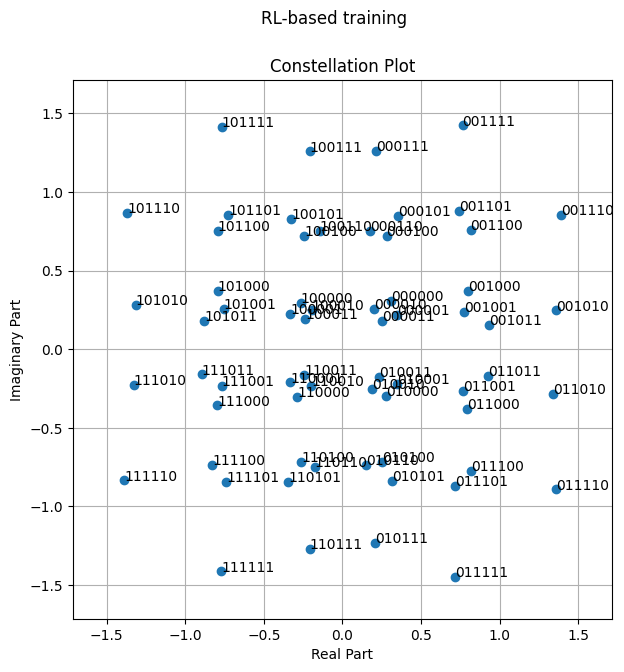

In [17]:
model_rl = E2ESystemRLTraining(training=False)
load_weights(model_rl, model_weights_path_rl_training)
fig = model_rl.constellation.show()
fig.suptitle('RL-based training');

In [18]:
%rm awgn_autoencoder_weights_conventional_training awgn_autoencoder_weights_rl_training awgn_autoencoder_results

## References

[1] T. O’Shea and J. Hoydis, "An Introduction to Deep Learning for the Physical Layer," in IEEE Transactions on Cognitive Communications and Networking, vol. 3, no. 4, pp. 563-575, Dec. 2017, doi: 10.1109/TCCN.2017.2758370.

[2] S. Cammerer, F. Ait Aoudia, S. Dörner, M. Stark, J. Hoydis and S. ten Brink, "Trainable Communication Systems: Concepts and Prototype," in IEEE Transactions on Communications, vol. 68, no. 9, pp. 5489-5503, Sept. 2020, doi: 10.1109/TCOMM.2020.3002915.

[3] F. Ait Aoudia and J. Hoydis, "Model-Free Training of End-to-End Communication Systems," in IEEE Journal on Selected Areas in Communications, vol. 37, no. 11, pp. 2503-2516, Nov. 2019, doi: 10.1109/JSAC.2019.2933891.